<a href="https://colab.research.google.com/github/christinaxliu/research/blob/main/JPL/HZExoplanetClassifier/DNNClassifier_v1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Deep Neural Network (DNN) model to predict exoplanet habitablity. The model is trained based on combined dataset obtained by joining data from NASA Exoplanet Archive (https://exoplanetarchive.ipac.caltech.edu/) and Habitable Worlds Catalog (https://phl.upr.edu/hwc).

In [ ]:
import warnings
import os
import pydotplus
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib import cm
from collections import Counter
from imblearn.combine import SMOTEENN
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import MinMaxScaler
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import IterativeImputer
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score
from sklearn.metrics import classification_report
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.callbacks import EarlyStopping
from keras import regularizers
from IPython import display
from IPython.display import Image
from six import StringIO
import pickle
from google.colab import drive

In [ ]:
#pd.options.mode.copy_on_write = True
warnings.simplefilter('ignore')

In [ ]:
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
nasa_exoplanets_filename = '/content/drive/My Drive/Colab Notebooks/research/JPL-Caltech/HZExoplanetClassifiers/DNNClassifier_v1/NASA_PSCompData_2024.09.15.csv'
nasa_exoplanets_data = pd.read_table(nasa_exoplanets_filename,
                                      skiprows=89,
                                      sep=',',
                                      header=None,
                                      index_col=None,
                                      names = ['pl_name', 'hostname', 'sy_snum', 'sy_pnum', 'discoverymethod', 'disc_year', 'disc_facility', 'pl_controv_flag',
                                                'pl_orbper', 'pl_orbpererr1', 'pl_orbpererr2', 'pl_orbperlim', 'pl_orbsmax', 'pl_orbsmaxerr1', 'pl_orbsmaxerr2', 'pl_orbsmaxlim',
                                                'pl_rade', 'pl_radeerr1', 'pl_radeerr2', 'pl_radelim', 'pl_radj', 'pl_radjerr1', 'pl_radjerr2', 'pl_radjlim',
                                                'pl_bmasse', 'pl_bmasseerr1', 'pl_bmasseerr2', 'pl_bmasselim', 'pl_bmassj', 'pl_bmassjerr1', 'pl_bmassjerr2', 'pl_bmassjlim',
                                                'pl_bmassprov', 'pl_orbeccen', 'pl_orbeccenerr1', 'pl_orbeccenerr2', 'pl_orbeccenlim',
                                                'pl_insol', 'pl_insolerr1', 'pl_insolerr2', 'pl_insollim', 'pl_eqt', 'pl_eqterr1', 'pl_eqterr2', 'pl_eqtlim',
                                                'ttv_flag', 'st_spectype', 'st_teff', 'st_tefferr1', 'st_tefferr2', 'st_tefflim', 'st_rad', 'st_raderr1', 'st_raderr2', 'st_radlim',
                                                'st_mass', 'st_masserr1', 'st_masserr2', 'st_masslim', 'st_met', 'st_meterr1', 'st_meterr2', 'st_metlim',
                                                'st_metratio', 'st_logg', 'st_loggerr1', 'st_loggerr2', 'st_logglim', 'rastr', 'ra', 'decstr', 'dec',
                                                'sy_dist', 'sy_disterr1', 'sy_disterr2', 'sy_vmag', 'sy_vmagerr1', 'sy_vmagerr2', 'sy_kmag', 'sy_kmagerr1', 'sy_kmagerr2',
                                                'sy_gaiamag', 'sy_gaiamagerr1', 'sy_gaiamagerr2'],
                                      skipfooter=0,
                                      engine='python')

In [ ]:
# Sanity check the first several rows of data to ensure data is read correctly
nasa_exoplanets_data.head()

,pl_name,hostname,sy_snum,sy_pnum,discoverymethod,disc_year,disc_facility,pl_controv_flag,pl_orbper,pl_orbpererr1,...,sy_disterr2,sy_vmag,sy_vmagerr1,sy_vmagerr2,sy_kmag,sy_kmagerr1,sy_kmagerr2,sy_gaiamag,sy_gaiamagerr1,sy_gaiamagerr2
0,11 Com b,11 Com,2,1,Radial Velocity,2007,Xinglong Station,0,323.21000,0.06000,...,-1.9238,4.72307,0.023,-0.023,2.282,0.346,-0.346,4.44038,0.003848,-0.003848
1,11 UMi b,11 UMi,1,1,Radial Velocity,2009,Thueringer Landessternwarte Tautenburg,0,516.21997,3.20000,...,-1.9765,5.01300,0.005,-0.005,1.939,0.270,-0.270,4.56216,0.003903,-0.003903
2,14 And b,14 And,1,1,Radial Velocity,2008,Okayama Astrophysical Observatory,0,186.76000,0.11000,...,-0.7140,5.23133,0.023,-0.023,2.331,0.240,-0.240,4.91781,0.002826,-0.002826
3,14 Her b,14 Her,1,2,Radial Velocity,2002,W. M. Keck Observatory,0,1765.03890,1.67709,...,-0.0073,6.61935,0.023,-0.023,4.714,0.016,-0.016,6.38300,0.000351,-0.000351
4,16 Cyg B b,16 Cyg B,3,1,Radial Velocity,1996,Multiple Observatories,0,798.50000,1.00000,...,-0.0111,6.21500,0.016,-0.016,4.651,0.016,-0.016,6.06428,0.000603,-0.000603


In [ ]:
# Sanity check the last several rows of data to ensure data is read correctly.
nasa_exoplanets_data.tail()

,pl_name,hostname,sy_snum,sy_pnum,discoverymethod,disc_year,disc_facility,pl_controv_flag,pl_orbper,pl_orbpererr1,...,sy_disterr2,sy_vmag,sy_vmagerr1,sy_vmagerr2,sy_kmag,sy_kmagerr1,sy_kmagerr2,sy_gaiamag,sy_gaiamagerr1,sy_gaiamagerr2
5751,ups And b,ups And,2,3,Radial Velocity,1996,Lick Observatory,0,4.617033,0.000023,...,-0.06290,4.09565,0.023,-0.023,2.859,0.274,-0.274,3.98687,0.008937,-0.008937
5752,ups And c,ups And,2,3,Radial Velocity,1999,Multiple Observatories,0,241.258000,0.064000,...,-0.06290,4.09565,0.023,-0.023,2.859,0.274,-0.274,3.98687,0.008937,-0.008937
5753,ups And d,ups And,2,3,Radial Velocity,1999,Multiple Observatories,0,1276.460000,0.570000,...,-0.06290,4.09565,0.023,-0.023,2.859,0.274,-0.274,3.98687,0.008937,-0.008937
5754,ups Leo b,ups Leo,1,1,Radial Velocity,2021,Okayama Astrophysical Observatory,0,385.200000,2.800000,...,-0.89630,4.30490,0.023,-0.023,2.184,0.248,-0.248,4.03040,0.008513,-0.008513
5755,xi Aql b,xi Aql,1,1,Radial Velocity,2007,Okayama Astrophysical Observatory,0,136.970000,0.110000,...,-0.55975,4.70964,0.023,-0.023,2.171,0.220,-0.220,4.42501,0.003837,-0.003837


In [ ]:
# Get the statistics about the data
nasa_exoplanets_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5756 entries, 0 to 5755
Data columns (total 84 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   pl_name          5756 non-null   object 
 1   hostname         5756 non-null   object 
 2   sy_snum          5756 non-null   int64  
 3   sy_pnum          5756 non-null   int64  
 4   discoverymethod  5756 non-null   object 
 5   disc_year        5756 non-null   int64  
 6   disc_facility    5756 non-null   object 
 7   pl_controv_flag  5756 non-null   int64  
 8   pl_orbper        5480 non-null   float64
 9   pl_orbpererr1    4979 non-null   float64
 10  pl_orbpererr2    4979 non-null   float64
 11  pl_orbperlim     5480 non-null   float64
 12  pl_orbsmax       5475 non-null   float64
 13  pl_orbsmaxerr1   2863 non-null   float64
 14  pl_orbsmaxerr2   2863 non-null   float64
 15  pl_orbsmaxlim    5476 non-null   float64
 16  pl_rade          5735 non-null   float64
 17  pl_radeerr1   

In [ ]:
# Only selects exoplanets with pl_controv_flag == 0
nasa_exoplanets_data = nasa_exoplanets_data.loc[(nasa_exoplanets_data['pl_controv_flag'] == 0)]

In [ ]:
nasa_exoplanets_data = nasa_exoplanets_data.loc[
    (~np.isnan(nasa_exoplanets_data['sy_snum'])) & (nasa_exoplanets_data['sy_snum'] == 1)
    & ~np.isnan(nasa_exoplanets_data['st_teff'])
    & ~np.isnan(nasa_exoplanets_data['st_rad'])
    & ~np.isnan(nasa_exoplanets_data['pl_orbsmax'])]

In [ ]:
hwc_exoplanets_filename = '/content/drive/My Drive/Colab Notebooks/research/JPL-Caltech/HZExoplanetClassifiers/DNNClassifier_v1/hwc-09-06-2024.csv'
hwc_exoplanets_data = pd.read_csv(hwc_exoplanets_filename)
hwc_exoplanets_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5599 entries, 0 to 5598
Columns: 118 entries, P_NAME to S_CONSTELLATION_ENG
dtypes: float64(81), int64(18), object(19)
memory usage: 5.0+ MB


In [ ]:
hwc_exoplanets_data = hwc_exoplanets_data.loc[~np.isnan(hwc_exoplanets_data['P_HABITABLE'])]
hwc_exoplanets_data.info()

<class 'pandas.core.frame.DataFrame'>
Index: 5599 entries, 0 to 5598
Columns: 118 entries, P_NAME to S_CONSTELLATION_ENG
dtypes: float64(81), int64(18), object(19)
memory usage: 5.1+ MB


In [ ]:
exoplanets_data = pd.merge(nasa_exoplanets_data,
                           hwc_exoplanets_data[['P_HABITABLE']],
                           how="left",
                           left_on=nasa_exoplanets_data['pl_name'].str.lower(),
                           right_on=hwc_exoplanets_data['P_NAME'].str.lower())
exoplanets_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4712 entries, 0 to 4711
Data columns (total 86 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   key_0            4712 non-null   object 
 1   pl_name          4712 non-null   object 
 2   hostname         4712 non-null   object 
 3   sy_snum          4712 non-null   int64  
 4   sy_pnum          4712 non-null   int64  
 5   discoverymethod  4712 non-null   object 
 6   disc_year        4712 non-null   int64  
 7   disc_facility    4712 non-null   object 
 8   pl_controv_flag  4712 non-null   int64  
 9   pl_orbper        4670 non-null   float64
 10  pl_orbpererr1    4191 non-null   float64
 11  pl_orbpererr2    4191 non-null   float64
 12  pl_orbperlim     4670 non-null   float64
 13  pl_orbsmax       4712 non-null   float64
 14  pl_orbsmaxerr1   2190 non-null   float64
 15  pl_orbsmaxerr2   2190 non-null   float64
 16  pl_orbsmaxlim    4712 non-null   float64
 17  pl_rade       

In [ ]:
exoplanets_data.to_csv('/content/drive/My Drive/Colab Notebooks/research/JPL-Caltech/HZExoplanetClassifiers/DNNClassifier_v1/NasaJoinedWithHWCData-09-15-2024.csv')

In [ ]:
# Drop data fields that are not relevant to the training
training_prep_data = exoplanets_data.drop(['key_0','pl_name', 'hostname', 'sy_snum',
                                            'discoverymethod', 'disc_year', 'disc_facility', 'pl_controv_flag',
                                            'pl_orbpererr1', 'pl_orbpererr2', 'pl_orbperlim',
                                            'pl_orbsmaxerr1', 'pl_orbsmaxerr2', 'pl_orbperlim',
                                            'pl_orbsmaxerr1', 'pl_orbsmaxerr2', 'pl_orbsmaxlim',
                                            'pl_radeerr1', 'pl_radeerr2', 'pl_radelim',
                                            'pl_radjerr1', 'pl_radjerr2', 'pl_radjlim',
                                            'pl_bmasseerr1', 'pl_bmasseerr2', 'pl_bmasselim',
                                            'pl_bmassjerr1', 'pl_bmassjerr2', 'pl_bmassjlim',
                                            'pl_orbeccenerr1', 'pl_orbeccenerr2', 'pl_orbeccenlim',
                                            'pl_insolerr1', 'pl_insolerr2', 'pl_insollim',
                                            'pl_eqterr1', 'pl_eqterr2', 'pl_eqtlim',
                                            'ttv_flag', 'st_tefferr1', 'st_tefferr2', 'st_tefflim',
                                            'st_raderr1', 'st_raderr2', 'st_radlim',
                                            'st_masserr1', 'st_masserr2', 'st_masslim',
                                            'st_meterr1', 'st_meterr2', 'st_metlim',
                                            'st_loggerr1', 'st_loggerr2', 'st_logglim',
                                            'rastr', 'decstr',
                                            'sy_disterr1', 'sy_disterr2', 'sy_vmagerr1', 'sy_vmagerr2',
                                            'sy_kmagerr1', 'sy_kmagerr2', 'sy_gaiamagerr1', 'sy_gaiamagerr2'],
                                          axis = 1)

# Drop data fields that are duplicate to others
training_prep_data = training_prep_data.drop(['pl_bmassj', 'pl_radj'], axis = 1)
training_prep_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4712 entries, 0 to 4711
Data columns (total 23 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   sy_pnum       4712 non-null   int64  
 1   pl_orbper     4670 non-null   float64
 2   pl_orbsmax    4712 non-null   float64
 3   pl_rade       4703 non-null   float64
 4   pl_bmasse     4696 non-null   float64
 5   pl_bmassprov  4712 non-null   object 
 6   pl_orbeccen   4381 non-null   float64
 7   pl_insol      3677 non-null   float64
 8   pl_eqt        3843 non-null   float64
 9   st_spectype   1597 non-null   object 
 10  st_teff       4712 non-null   float64
 11  st_rad        4712 non-null   float64
 12  st_mass       4711 non-null   float64
 13  st_met        4542 non-null   float64
 14  st_metratio   4525 non-null   object 
 15  st_logg       4704 non-null   float64
 16  ra            4712 non-null   float64
 17  dec           4712 non-null   float64
 18  sy_dist       4696 non-null 

In [ ]:
training_prep_data['P_HABITABLE'].value_counts()

,count
P_HABITABLE,
0.0,4528
2.0,31
1.0,24


In [ ]:
training_prep_data = training_prep_data.loc[~np.isnan(training_prep_data['P_HABITABLE'])]
training_prep_data['hz_label'] = training_prep_data['P_HABITABLE'].apply(np.int64)
training_prep_data.loc[training_prep_data['hz_label'] == 2, 'hz_label'] = 1
training_prep_data['hz_label'].value_counts()

,count
hz_label,
0,4528
1,55


In [ ]:
training_prep_data = training_prep_data.drop(['P_HABITABLE'], axis = 1)
training_prep_data.info()

<class 'pandas.core.frame.DataFrame'>
Index: 4583 entries, 0 to 4711
Data columns (total 23 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   sy_pnum       4583 non-null   int64  
 1   pl_orbper     4546 non-null   float64
 2   pl_orbsmax    4583 non-null   float64
 3   pl_rade       4574 non-null   float64
 4   pl_bmasse     4567 non-null   float64
 5   pl_bmassprov  4583 non-null   object 
 6   pl_orbeccen   4287 non-null   float64
 7   pl_insol      3564 non-null   float64
 8   pl_eqt        3722 non-null   float64
 9   st_spectype   1566 non-null   object 
 10  st_teff       4583 non-null   float64
 11  st_rad        4583 non-null   float64
 12  st_mass       4582 non-null   float64
 13  st_met        4432 non-null   float64
 14  st_metratio   4415 non-null   object 
 15  st_logg       4576 non-null   float64
 16  ra            4583 non-null   float64
 17  dec           4583 non-null   float64
 18  sy_dist       4568 non-null   flo

In [ ]:
# Calculate the missing value % for each data field, then sort data fields by the missing value percentages
missing_value_count = training_prep_data.isnull().sum().sort_values(ascending=False)
missing_value_percentage = ((training_prep_data.isnull().sum() / training_prep_data.isnull().count()) * 100).sort_values(ascending=False)
missing_value_percentage_data = pd.concat([missing_value_count, missing_value_percentage], axis = 1, keys = ['Count', '%'])
missing_value_percentage_data.head(50)

,Count,%
st_spectype,3017,65.830242
pl_insol,1019,22.234344
pl_eqt,861,18.786821
pl_orbeccen,296,6.458652
st_metratio,168,3.665721
st_met,151,3.294785
pl_orbper,37,0.807331
sy_gaiamag,33,0.720052
pl_bmasse,16,0.349116
sy_dist,15,0.327297


In [ ]:
# Drop off data fields with missing value % >= 25%
training_prep_data = training_prep_data.drop(['st_spectype'], axis = 1)
training_prep_data.info()

<class 'pandas.core.frame.DataFrame'>
Index: 4583 entries, 0 to 4711
Data columns (total 22 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   sy_pnum       4583 non-null   int64  
 1   pl_orbper     4546 non-null   float64
 2   pl_orbsmax    4583 non-null   float64
 3   pl_rade       4574 non-null   float64
 4   pl_bmasse     4567 non-null   float64
 5   pl_bmassprov  4583 non-null   object 
 6   pl_orbeccen   4287 non-null   float64
 7   pl_insol      3564 non-null   float64
 8   pl_eqt        3722 non-null   float64
 9   st_teff       4583 non-null   float64
 10  st_rad        4583 non-null   float64
 11  st_mass       4582 non-null   float64
 12  st_met        4432 non-null   float64
 13  st_metratio   4415 non-null   object 
 14  st_logg       4576 non-null   float64
 15  ra            4583 non-null   float64
 16  dec           4583 non-null   float64
 17  sy_dist       4568 non-null   float64
 18  sy_vmag       4576 non-null   flo

In [ ]:
training_prep_data.select_dtypes(include = ['object']).columns

Index(['pl_bmassprov', 'st_metratio'], dtype='object')

In [ ]:
# Calculate the missing value % for the categorial data field, then sort categorial data fields by the missing value percentages
categorial_data_fields = training_prep_data.select_dtypes(include = ['object'])
missing_value_count = categorial_data_fields.isnull().sum().sort_values(ascending=False)
missing_value_percentage = ((categorial_data_fields.isnull().sum() / categorial_data_fields.isnull().count()) * 100).sort_values(ascending=False)
missing_value_percentage_data = pd.concat([missing_value_count, missing_value_percentage], axis = 1, keys = ['Count', '%'])
missing_value_percentage_data.head(50)

,Count,%
st_metratio,168,3.665721
pl_bmassprov,0,0.000000


In [ ]:
# Fill in the missing values in categorical data fields with mode
training_prep_data['st_metratio'] = training_prep_data['st_metratio'].fillna(training_prep_data['st_metratio'].mode()[0])

In [ ]:
# Encode categorical data fields to numeric values with Label Encoder
encoders = {}
for column in training_prep_data.select_dtypes(include = ['object']).columns:
    encoders[column] = LabelEncoder()
    training_prep_data[column] = encoders[column].fit_transform(training_prep_data[column])
training_prep_data.info()

<class 'pandas.core.frame.DataFrame'>
Index: 4583 entries, 0 to 4711
Data columns (total 22 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   sy_pnum       4583 non-null   int64  
 1   pl_orbper     4546 non-null   float64
 2   pl_orbsmax    4583 non-null   float64
 3   pl_rade       4574 non-null   float64
 4   pl_bmasse     4567 non-null   float64
 5   pl_bmassprov  4583 non-null   int64  
 6   pl_orbeccen   4287 non-null   float64
 7   pl_insol      3564 non-null   float64
 8   pl_eqt        3722 non-null   float64
 9   st_teff       4583 non-null   float64
 10  st_rad        4583 non-null   float64
 11  st_mass       4582 non-null   float64
 12  st_met        4432 non-null   float64
 13  st_metratio   4583 non-null   int64  
 14  st_logg       4576 non-null   float64
 15  ra            4583 non-null   float64
 16  dec           4583 non-null   float64
 17  sy_dist       4568 non-null   float64
 18  sy_vmag       4576 non-null   flo

In [ ]:
training_prep_data['pl_bmassprov'].value_counts()

,count
pl_bmassprov,
0,2564
1,1321
3,685
2,13


In [ ]:
training_prep_data['st_metratio'].value_counts()

,count
st_metratio,
0,4077
1,506


In [ ]:
# Fill in the missing values for the numeric data fields with Multivariate Imputation by Chained Equation (MICE) imputation
# https://journalofbigdata.springeropen.com/articles/10.1186/s40537-020-00313-w
imputed_training_prep_data = training_prep_data.copy(deep = True)
mice_imputer = IterativeImputer()
imputed_training_prep_data.iloc[:, :] = mice_imputer.fit_transform(training_prep_data)
imputed_training_prep_data.info()

<class 'pandas.core.frame.DataFrame'>
Index: 4583 entries, 0 to 4711
Data columns (total 22 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   sy_pnum       4583 non-null   int64  
 1   pl_orbper     4583 non-null   float64
 2   pl_orbsmax    4583 non-null   float64
 3   pl_rade       4583 non-null   float64
 4   pl_bmasse     4583 non-null   float64
 5   pl_bmassprov  4583 non-null   int64  
 6   pl_orbeccen   4583 non-null   float64
 7   pl_insol      4583 non-null   float64
 8   pl_eqt        4583 non-null   float64
 9   st_teff       4583 non-null   float64
 10  st_rad        4583 non-null   float64
 11  st_mass       4583 non-null   float64
 12  st_met        4583 non-null   float64
 13  st_metratio   4583 non-null   int64  
 14  st_logg       4583 non-null   float64
 15  ra            4583 non-null   float64
 16  dec           4583 non-null   float64
 17  sy_dist       4583 non-null   float64
 18  sy_vmag       4583 non-null   flo

In [ ]:
habitability_status_counts = Counter(imputed_training_prep_data['hz_label'])
for habitability_status_label, habitability_status_count in habitability_status_counts.items():
    habitability_status_percentage = (habitability_status_count / len(imputed_training_prep_data['hz_label'])) * 100
    print('hz_label=%d, count=%d (%.3f%%)' % (habitability_status_label, habitability_status_count, habitability_status_percentage))

hz_label=0, count=4528 (98.800%)
hz_label=1, count=55 (1.200%)


In [ ]:
features_to_balance, labels_to_balance = imputed_training_prep_data.drop(['hz_label'], axis = 1), imputed_training_prep_data.hz_label

smoteenn = SMOTEENN(random_state=0)
balanced_features, balanced_labels = smoteenn.fit_resample(features_to_balance, labels_to_balance)

habitability_status_counts = Counter(balanced_labels)
for habitability_status_label, habitability_status_count in habitability_status_counts.items():
    habitability_status_percentage = (habitability_status_count / len(balanced_labels)) * 100
    print('hz_label=%d, count=%d (%.3f%%)' % (habitability_status_label, habitability_status_count, habitability_status_percentage))

hz_label=0, count=4420 (49.518%)
hz_label=1, count=4506 (50.482%)


In [ ]:
balanced_training_prep_data = balanced_features
balanced_training_prep_data['hz_label'] = balanced_labels
balanced_training_prep_data.shape

(8926, 22)

<Axes: >

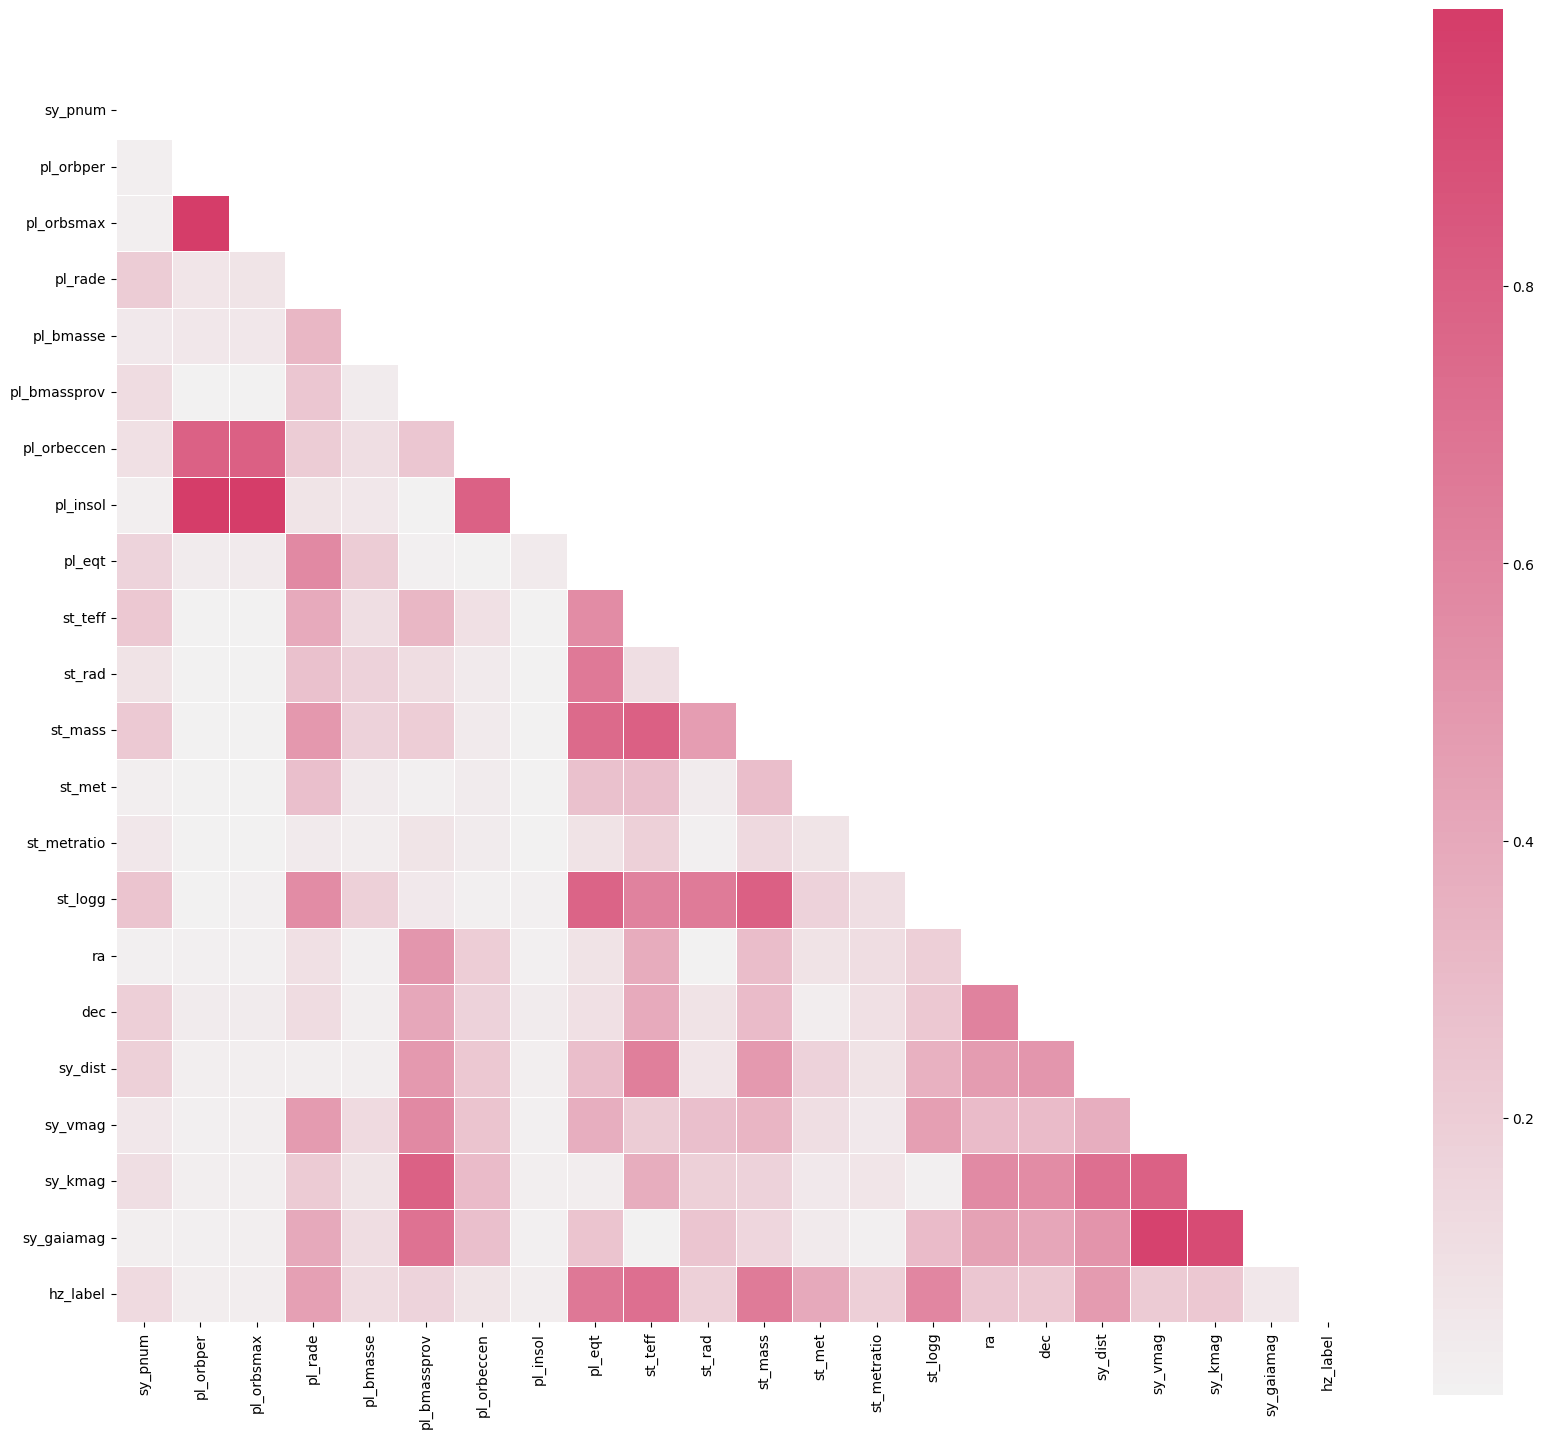

In [ ]:
correlation_matrix = balanced_training_prep_data.corr().abs()

mask = np.triu(np.ones_like(correlation_matrix, dtype = np.bool_))
f, ax = plt.subplots(figsize = (20, 20))
cmap = sns.diverging_palette(255, 0, as_cmap = True)
sns.heatmap(correlation_matrix,
            mask = mask,
            cmap = cmap,
            vmax = None,
            center = 0,
            square = True,
            annot = False,
            linewidths = .5,
            cbar_kws = {"shrink": 0.9})

In [ ]:
# Drop highly correlated data fields
preprocessed_training_data = balanced_training_prep_data.drop(['pl_orbeccen', 'pl_insol', 'sy_gaiamag'], axis = 1)

In [ ]:
preprocessed_training_data = preprocessed_training_data.drop(['pl_eqt'], axis = 1)
features = preprocessed_training_data.drop('hz_label', axis = 1)
labels = preprocessed_training_data['hz_label']
features.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8926 entries, 0 to 8925
Data columns (total 17 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   sy_pnum       8926 non-null   int64  
 1   pl_orbper     8926 non-null   float64
 2   pl_orbsmax    8926 non-null   float64
 3   pl_rade       8926 non-null   float64
 4   pl_bmasse     8926 non-null   float64
 5   pl_bmassprov  8926 non-null   int64  
 6   st_teff       8926 non-null   float64
 7   st_rad        8926 non-null   float64
 8   st_mass       8926 non-null   float64
 9   st_met        8926 non-null   float64
 10  st_metratio   8926 non-null   int64  
 11  st_logg       8926 non-null   float64
 12  ra            8926 non-null   float64
 13  dec           8926 non-null   float64
 14  sy_dist       8926 non-null   float64
 15  sy_vmag       8926 non-null   float64
 16  sy_kmag       8926 non-null   float64
dtypes: float64(14), int64(3)
memory usage: 1.2 MB


In [ ]:
# Split the preprocessed_training_data into train and test subsets
features_train, features_test, labels_train, labels_test = train_test_split(features,
                                                                            labels,
                                                                            test_size=0.28,
                                                                            stratify=labels,
                                                                            random_state=42)

print(f"features_train dimensions: {features_train.shape}")
print(f"features_test dimensions: {features_test.shape}")
print(f"labels_train dimensions: {labels_train.shape}")
print(f"labels_test dimensions: {labels_test.shape}")

features_train dimensions: (6426, 17)
features_test dimensions: (2500, 17)
labels_train dimensions: (6426,)
labels_test dimensions: (2500,)


In [ ]:
minMaxScaler = MinMaxScaler()
features_train = minMaxScaler.fit_transform(features_train)
features_test = minMaxScaler.fit_transform(features_test)

In [ ]:
early_stopping = EarlyStopping(
    min_delta=0.001, # minimium amount of change to count as an improvement
    patience=1, # how many epochs to wait before stopping
    verbose=1,
    restore_best_weights=True)

dnn_classifier = keras.Sequential([
    layers.Dense(64, kernel_regularizer=regularizers.l2(0.01), activation='relu', input_shape=[17]),
    layers.Dropout(rate=0.5),
    layers.BatchNormalization(),
    layers.Dense(32, kernel_regularizer=regularizers.l2(0.01), activation='relu'),
    layers.Dropout(rate=0.5),
    layers.BatchNormalization(),
    layers.Dense(16, kernel_regularizer=regularizers.l2(0.01), activation='relu'),
    layers.Dropout(rate=0.5),
    layers.BatchNormalization(),
    layers.Dense(1, activation='sigmoid')])

optimizer = keras.optimizers.Adam(learning_rate=0.0005)

dnn_classifier.compile(
    optimizer=optimizer,
    loss='binary_crossentropy',
    metrics=['binary_accuracy'])

dnn_classifier_training_history = dnn_classifier.fit(
    features_train, labels_train,
    validation_data=(features_test, labels_test),
    shuffle=True,
    batch_size=1024,
    epochs=50,
    callbacks=[early_stopping])

dnn_classifier.summary()

Epoch 1/50
7/7 ━━━━━━━━━━━━━━━━━━━━ 3s 52ms/step - binary_accuracy: 0.5224 - loss: 1.8086 - val_binary_accuracy: 0.5088 - val_loss: 1.5947
Epoch 2/50
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - binary_accuracy: 0.5282 - loss: 1.7621 - val_binary_accuracy: 0.5068 - val_loss: 1.5720
Epoch 3/50
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - binary_accuracy: 0.5234 - loss: 1.7508 - val_binary_accuracy: 0.5320 - val_loss: 1.5499
Epoch 4/50
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - binary_accuracy: 0.5365 - loss: 1.6868 - val_binary_accuracy: 0.5484 - val_loss: 1.5281
Epoch 5/50
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - binary_accuracy: 0.5590 - loss: 1.6411 - val_binary_accuracy: 0.5760 - val_loss: 1.5068
Epoch 6/50
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - binary_accuracy: 0.5553 - loss: 1.6211 - val_binary_accuracy: 0.6308 - val_loss: 1.4857
Epoch 7/50
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - binary_accuracy: 0.5715 - loss: 1.5644 - val_binary_accuracy: 0.7064 - val_loss: 1.4651
Epoch 8/50
7/7 ━━━━━━━━━━━━

Model: "sequential_19"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ dense_76 (Dense)                     │ (None, 64)                  │           1,152 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_57 (Dropout)                 │ (None, 64)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_57               │ (None, 64)                  │             256 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_77 (Dense)                     │ (None, 32)                  │           2,080 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_58 (Dropout)                 │ (None, 32)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_58               │ (None, 32)                  │             128 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_78 (Dense)                     │ (None, 16)                  │             528 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_59 (Dropout)                 │ (None, 16)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_59               │ (None, 16)                  │              64 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_79 (Dense)                     │ (None, 1)                   │              17 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 12,229 (47.77 KB)

 Trainable params: 4,001 (15.63 KB)

 Non-trainable params: 224 (896.00 B)

 Optimizer params: 8,004 (31.27 KB)

Best Validation Loss: 0.7107
Best Validation Accuracy: 0.8944


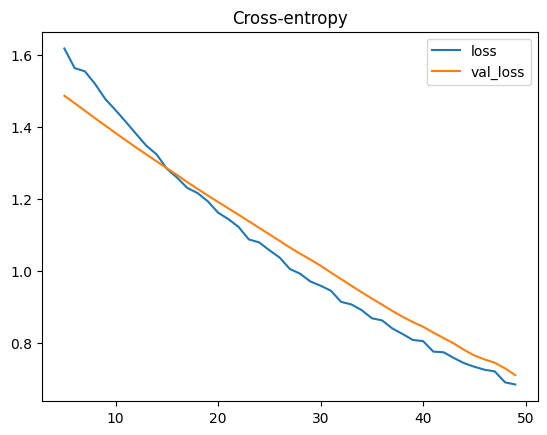

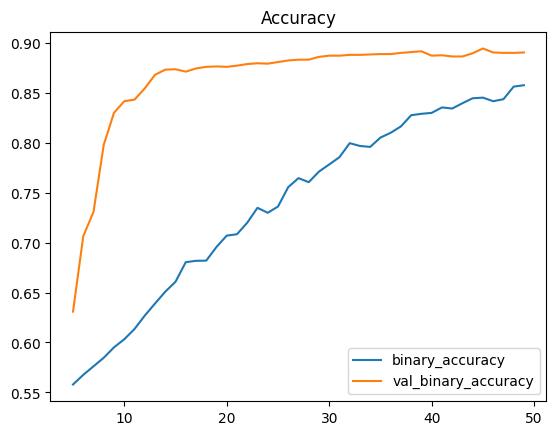

In [ ]:
dnn_classifier_training_history_df = pd.DataFrame(dnn_classifier_training_history.history)

# Start the plot at epoch 5
dnn_classifier_training_history_df.loc[5:, ['loss', 'val_loss']].plot(title="Cross-entropy")
dnn_classifier_training_history_df.loc[5:, ['binary_accuracy', 'val_binary_accuracy']].plot(title="Accuracy")

print(("Best Validation Loss: {:0.4f}" +\
      "\nBest Validation Accuracy: {:0.4f}")\
      .format(dnn_classifier_training_history_df['val_loss'].min(),
              dnn_classifier_training_history_df['val_binary_accuracy'].max()))

In [ ]:
dnn_classifier_predictions = dnn_classifier.predict(features_test)
dnn_classifier_predictions

84/84 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step


array([[0.25340995],
       [0.72147304],
       [0.26134136],
       ...,
       [0.20020124],
       [0.29823875],
       [0.35896146]], dtype=float32)